# CNN on CIFAR-10

In this notebook you need to put what you have learned into practice, and create your own convolutional classifier for the CIFAR-10 dataset.

The images in CIFAR-10 are RGB images (3 channels) with size 32x32 (so they have size 3x32x32). There are 10 different classes. See examples below.

![cifar10](https://github.com/DeepLearningDTU/02456-deep-learning-with-PyTorch/blob/master/static_files/cifar10.png?raw=1)


## Preliminaries

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from sklearn import metrics

sns.set_style("whitegrid")

def accuracy(target, pred):
    return metrics.accuracy_score(target.detach().cpu().numpy(), pred.detach().cpu().numpy())

def compute_confusion_matrix(target, pred, normalize=None):
    return metrics.confusion_matrix(
        target.detach().cpu().numpy(), 
        pred.detach().cpu().numpy(),
        normalize=normalize
    )

def show_image(img):
    img = img.detach().cpu()
    img = img / 2 + 0.5   # unnormalize
    with sns.axes_style("white"):
        plt.figure(figsize=(8, 8))
        plt.imshow(img.permute((1, 2, 0)).numpy())
        plt.axis('off')
        plt.show()

In [2]:
# The output of torchvision datasets are PIL images in the range [0, 1]. 
# We transform them to PyTorch tensors and rescale them to be in the range [-1, 1].
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),  # subtract 0.5 and divide by 0.5
    ]
)

batch_size = 64  # both for training and testing

# Load datasets
train_set = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0, drop_last=False)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, drop_last=True)

# Map from class index to class name.
classes = {index: name for name, index in train_set.class_to_idx.items()}

Files already downloaded and verified
Files already downloaded and verified


In [3]:
print("Training data")
print("Number of points:", len(train_set))
x, y = next(iter(train_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(train_set.targets))} (unique labels: {set(train_set.targets)})")

print("\nTest data")
print("Number of points:", len(test_set))
x, y = next(iter(test_loader))
print("Batch dimension (B x C x H x W):", x.shape)
print(f"Number of distinct labels: {len(set(test_set.targets))} (unique labels: {set(test_set.targets)})")

n_classes = len(set(test_set.targets))



Training data
Number of points: 50000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})

Test data
Number of points: 10000
Batch dimension (B x C x H x W): torch.Size([64, 3, 32, 32])
Number of distinct labels: 10 (unique labels: {0, 1, 2, 3, 4, 5, 6, 7, 8, 9})


### Show example images

Run multiple times to see different examples.

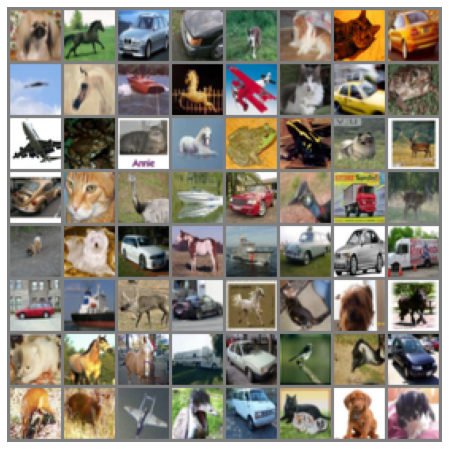

In [4]:
# Get random training images and show them.
images, labels = iter(train_loader).next()
show_image(torchvision.utils.make_grid(images))

## Define a convolutional neural network


**Assignment 1:** Define a convolutional neural network. 
You may use the code from previous notebooks.
We suggest that you start with a small network, and make sure that everything is working.
Once you can train successfully, come back and improve the architecture.

**Answer**

The neural network is heavily inspired by the example given by pytorch at https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html


In [7]:
class PrintSize(nn.Module):
    """Utility module to print current shape of a Tensor in Sequential, only at the first pass."""
    
    first = True
    
    def forward(self, x):
        if self.first:
            print(f"Size: {x.size()}")
            self.first = False
        return x


class Model(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=1)
        self.fc1 = nn.Linear(6*6*16, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, self.num_classes)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

engine = 'cpu'              # use cuda or cpu
model = Model(n_classes)
device = torch.device(engine)  
model.to(device)
print(model)

Model(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


## Define a loss function and optimizer

**Assignment 2:** Define the loss function and optimizer.
You might need to experiment a bit with the learning rate.

In [8]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

## Train the network

**Assignment 3:** Finish the training loop below. 
Start by using a small number of epochs (e.g. 2).
Even with a low number of epochs you should be able to see results that are better than chance.
When everything is working increase the number of epochs to find out how good your network really is.

In [10]:
# Test the forward pass with dummy data
out = model(torch.randn(2, 3, 32, 32, device=device))
print("Output shape:", out.size())
print(f"Output logits:\n{out.detach().cpu().numpy()}")
print(f"Output probabilities:\n{out.softmax(1).detach().cpu().numpy()}")

Output shape: torch.Size([2, 10])
Output logits:
[[ 0.1584543   0.00498517 -0.01732692 -0.03559273  0.0425617   0.08286311
  -0.03144718 -0.01195172 -0.01289492  0.09645398]
 [ 0.17495692 -0.00280619 -0.0043089  -0.06007182  0.02826533  0.06571793
  -0.04799685 -0.02149886 -0.01526941  0.08964171]]
Output probabilities:
[[0.11375675 0.09757227 0.09541933 0.09369224 0.10130845 0.10547472
  0.09408145 0.09593361 0.09584317 0.10691799]
 [0.11640856 0.09745035 0.09730402 0.09202658 0.10052581 0.10436216
  0.09314453 0.09564566 0.09624334 0.10688899]]


In [8]:
num_epochs = 10
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    if (epoch+1)%1 == 0:
      print(f"Epoch number {epoch+1}")
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))      
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"                 test accuracy: {valid_accuracies[-1]}")
            
print(f'Highest test accuracy throughout: {max(valid_accuracies)}')
print("Finished training.")

Epoch number 1
Step 500     training accuracy: 0.28721875
                 test accuracy: 0.4021
Epoch number 2
Step 1000    training accuracy: 0.47778096330275227
                 test accuracy: 0.4929
Step 1500    training accuracy: 0.5099375
                 test accuracy: 0.5151
Epoch number 3
Step 2000    training accuracy: 0.5613532110091743
                 test accuracy: 0.5636
Epoch number 4
Step 2500    training accuracy: 0.5974025974025974
                 test accuracy: 0.5721
Step 3000    training accuracy: 0.60321875
                 test accuracy: 0.572
Epoch number 5
Step 3500    training accuracy: 0.6345346102150538
                 test accuracy: 0.621
Epoch number 6
Step 4000    training accuracy: 0.6680555555555555
                 test accuracy: 0.6089
Step 4500    training accuracy: 0.6674375
                 test accuracy: 0.6244
Epoch number 7
Step 5000    training accuracy: 0.6905438311688312
                 test accuracy: 0.6325
Epoch number 8
Step 5500    tr

In [20]:
import itertools
test_mode = 0
if test_mode == 1:
  conv_layers = [1]
  out_channels = [16]
  kernel_size = [5]
  padding = [0]
  stride = [1]
  pooling = [0]
  dropout = [0]
  batchnorm = [0]
else:
  # Only valid amount of conv layers are 1 or 2 at the moment, as it hasn't been
  # parameterised, and is simply implemented with lots of if-statements. Also, 
  # the second layer will take the inputs from the following parameters. First 
  # layer will be somewhat static.
  conv_layers = [1, 2]
  out_channels = [10, 16, 20]
  kernel_size = [3, 5, 7]
  padding = [0, 1]
  stride = [1]
  pooling = [0, 1]
  dropout = [0, 1]
  batchnorm = [0, 1]

setup_settings = [x for x in itertools.product(conv_layers, out_channels, kernel_size, padding, stride, pooling, dropout, batchnorm)]

total_number_of_setups = len(setup_settings)

setups = []
setup_scores = []

In [31]:
test_mode = 0

active_setups = setup_settings[:2] if test_mode == 1 else setup_settings

setups = []
setup_scores = []

In [34]:
from math import floor

# To run below for loop in parts, due to how long it takes to run, manually redefine active_setups under 'else' in this cell, and run the loop again (and don't run the previous cell if you want to keep history logged):
splits = 7
part = floor(total_number_of_setups / (splits))
parts = [i*part if i != len(range(1, splits+1)) else i*part + total_number_of_setups-part*splits for i in range(1, splits+1)]

###############
split = 0
###############

if test_mode == 1:
  active_setups = setup_settings[:2]
else:
  if split == 0:
    active_setups = setup_settings[:parts[0]]
  else:
    active_setups = setup_settings[parts[0]:parts[1]]
  floor(total_number_of_setups / (splits-1))
  # active_setups = setup_settings[50:100]
  # 5.5 parts: [:50], [50:100], [100:150] [150:200], [200:250] [250:288]

number_of_setups = len(active_setups)

In [ ]:
# HEADS UP! Below cell takes quite a while to run! (Unless in test_mode (=1))

for i, ii  in enumerate(active_setups):
  conv_layers, out_channels, kernel_size, padding, stride, pooling, dropout, batchnorm = ii
# for i, (out_channels, kernel_size, padding, stride, pooling, dropout, batchnorm) in enumerate(itertools.product(conv_layers, out_channels, kernel_size, padding, stride, pooling, dropout, batchnorm)):
  class Model(nn.Module):
      def __init__(self, num_classes):
          super().__init__()
          self.num_classes = num_classes

          if conv_layers == 1:
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
            conv_out_dim = (32 - kernel_size + 2*padding)/stride + 1
            if pooling == 1:
              conv_out_dim = conv_out_dim/2
              conv_to_linear = (conv_out_dim**2)*out_channels
            else:
              conv_to_linear = (conv_out_dim**2)*out_channels
          elif conv_layers == 2:
            self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=kernel_size, stride=stride, padding=padding)
            self.conv2 = nn.Conv2d(in_channels=6, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
            conv_out_dim = (32 - kernel_size + 2*padding)/stride + 1
            if pooling == 1:
              conv_out_dim = conv_out_dim/2
              conv_out_dim = (conv_out_dim - kernel_size + 2*padding)/stride + 1
              conv_out_dim = conv_out_dim/2
              conv_to_linear = (conv_out_dim**2)*out_channels
            else:
              conv_out_dim = (conv_out_dim - kernel_size + 2*padding)/stride + 1
              conv_to_linear = (conv_out_dim**2)*out_channels

          conv_to_linear = int(conv_to_linear)
          self.fc1 = nn.Linear(conv_to_linear, 120)
          self.fc2 = nn.Linear(120, 84)
          self.fc3 = nn.Linear(84, self.num_classes)

          # dropout
          self.dropout = torch.nn.Dropout(0.2)
          # batchnorm
          self.bn = torch.nn.BatchNorm1d(self.fc1.out_features)

      def forward(self, x):
          if conv_layers == 1:
            if pooling == 1:
              x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
            else:
              x = F.relu(self.conv1(x))
          elif conv_layers == 2:
            if pooling == 1:
              x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
              x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
            else:
              x = F.relu(self.conv1(x))
              x = F.relu(self.conv2(x))

          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          if dropout == 1:
            x = self.dropout(x)
          if batchnorm == 1:
            x = self.bn(x)
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x


  model = Model(n_classes)
  device = torch.device(engine)  # use cuda or cpu
  model.to(device)

  loss_fn = nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
  # optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

  # batch_size = 128
  num_epochs = 15
  validation_every_steps = 500

  step = 0
  model.train()

  train_accuracies = []
  valid_accuracies = []
  epochs = []
  
  for epoch in range(num_epochs):
      
      train_accuracies_batches = []
      
      for inputs, targets in train_loader:
          inputs, targets = inputs.to(device), targets.to(device)
          
          # Forward pass.
          output = model(inputs)
          
          # Compute loss.
          loss = loss_fn(output, targets)
          
          # Clean up gradients from the model.
          optimizer.zero_grad()
          
          # Compute gradients based on the loss from the current batch (backpropagation).
          loss.backward()
          
          # Take one optimizer step using the gradients computed in the previous step.
          optimizer.step()
          
          # Increment step counter
          step += 1
          
          # Compute accuracy.
          predictions = output.max(1)[1]
          train_accuracies_batches.append(accuracy(targets, predictions))
          
          if step % validation_every_steps == 0:
              
              # Append average training accuracy to list.
              train_accuracies.append(np.mean(train_accuracies_batches))
              
              train_accuracies_batches = []
          
              # Compute accuracies on validation set.
              valid_accuracies_batches = []
              with torch.no_grad():
                  model.eval()
                  for inputs, targets in test_loader:
                      inputs, targets = inputs.to(device), targets.to(device)
                      output = model(inputs)
                      loss = loss_fn(output, targets)

                      predictions = output.max(1)[1]

                      # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                      valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))
  
                  model.train()
                  
              # Append average validation accuracy to list.
              valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))
              epochs.append(epoch)

      #         print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
      #         print(f"                 test accuracy: {valid_accuracies[-1]}")
      # if (epoch+1)%1 == 0:
      #           print(f"Epoch number {epoch+1}")   
      # print(f'steps: {step}')

  # setups.append((i, out_channels, kernel_size, padding, stride, pooling, dropout, batchnorm, epochs[valid_accuracies.index(max(valid_accuracies))]+1, max(valid_accuracies)))
  setups.append((i,) + ii + (epochs[valid_accuracies.index(max(valid_accuracies))]+1, max(valid_accuracies)))
  
  # setup_scores.append(max(valid_accuracies))

  # print(f'---------- Setup {i+1} ----------')
  # print(f'Conv-layer out_channels:  {out_channels}')
  # print(f'Conv-layer kernel_size:   {kernel_size}')
  # print(f'Conv-layer padding:       {padding}')
  # print(f'Conv-layer stride:        {stride}')
  # print(f'Conv-layer pooling:       {pooling}')
  # print(f'Dropout:                  {dropout}')
  # print(f'Batchnorm:                {batchnorm}')
  # print(f'Highest test accuracy: {max(valid_accuracies)}')
  if (i%5 == 0) and (i != 0):
    print(f'Setups {i} of {number_of_setups}, completed.')
setup_scores = [x[-1] for x in setups]
high_score_index = setup_scores.index(max(setup_scores))

print(f'Highest test accuracy throughout: {setups[high_score_index][-1]}')
print("Finished.")

Setups 0 of 50, completed.
Setups 5 of 50, completed.


In [35]:
# Re-training of highest scoring setup from before. A risk is that the results might differ, if a different minima is hit in the optimizer.

# _, conv_layers, out_channels, kernel_size, padding, stride, pooling, dropout, batchnorm, epochs_final, _ = setups[high_score_index]

conv_layers, out_channels, kernel_size, padding, stride, pooling, dropout, batchnorm, epochs_final = (2, 16, 7, 1, 1, 1, 1, 1, 13)

class Model(nn.Module):
      def __init__(self, num_classes):
          super().__init__()
          self.num_classes = num_classes

          self.conv1 = nn.Conv2d(in_channels=3, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding)
          conv_out_dim = (32 - kernel_size + 2*padding)/stride + 1
          if pooling == 1:
            conv_out_dim = conv_out_dim/2
            conv_to_linear = (conv_out_dim**2)*out_channels
          else:
            conv_to_linear = (conv_out_dim**2)*out_channels
          conv_to_linear = int(conv_to_linear)
          self.fc1 = nn.Linear(conv_to_linear, 120)
          self.fc2 = nn.Linear(120, 84)
          self.fc3 = nn.Linear(84, self.num_classes)

          # dropout
          self.dropout = torch.nn.Dropout(0.2)
          # batchnorm
          self.bn = torch.nn.BatchNorm1d(self.fc1.out_features)

      def forward(self, x):
          if pooling == 1:
            x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
          else:
            x = F.relu(self.conv1(x))

          x = torch.flatten(x, 1)
          x = F.relu(self.fc1(x))
          if dropout == 1:
            x = self.dropout(x)
          if batchnorm == 1:
            x = self.bn(x)
          x = F.relu(self.fc2(x))
          x = self.fc3(x)
          return x


model = Model(n_classes)
device = torch.device(engine)  # use cuda or cpu
model.to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-6)
# optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

# batch_size = 128
num_epochs = epochs_final
validation_every_steps = 500

step = 0
model.train()

train_accuracies = []
valid_accuracies = []
        
for epoch in range(num_epochs):
    
    train_accuracies_batches = []
    
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        # Forward pass.
        output = model(inputs)
        
        # Compute loss.
        loss = loss_fn(output, targets)
        
        # Clean up gradients from the model.
        optimizer.zero_grad()
        
        # Compute gradients based on the loss from the current batch (backpropagation).
        loss.backward()
        
        # Take one optimizer step using the gradients computed in the previous step.
        optimizer.step()
        
        # Increment step counter
        step += 1
        
        # Compute accuracy.
        predictions = output.max(1)[1]
        train_accuracies_batches.append(accuracy(targets, predictions))
        
        if step % validation_every_steps == 0:
            
            # Append average training accuracy to list.
            train_accuracies.append(np.mean(train_accuracies_batches))
            
            train_accuracies_batches = []
        
            # Compute accuracies on validation set.
            valid_accuracies_batches = []
            with torch.no_grad():
                model.eval()
                for inputs, targets in test_loader:
                    inputs, targets = inputs.to(device), targets.to(device)
                    output = model(inputs)
                    loss = loss_fn(output, targets)

                    predictions = output.max(1)[1]

                    # Multiply by len(x) because the final batch of DataLoader may be smaller (drop_last=False).
                    valid_accuracies_batches.append(accuracy(targets, predictions) * len(inputs))

                model.train()
                
            # Append average validation accuracy to list.
            valid_accuracies.append(np.sum(valid_accuracies_batches) / len(test_set))      
            print(f"Step {step:<5}   training accuracy: {train_accuracies[-1]}")
            print(f"                 test accuracy: {valid_accuracies[-1]}")
    if (epoch+1)%1 == 0:
              print(f"Epoch number {epoch+1}")   
    print(f'steps: {step}')
            
print(f'Highest test accuracy throughout: {max(valid_accuracies)}')

Step 500     training accuracy: 0.42134375
                 test accuracy: 0.5188
Epoch number 1
steps: 782
Step 1000    training accuracy: 0.5227924311926605
                 test accuracy: 0.5493
Step 1500    training accuracy: 0.56303125
                 test accuracy: 0.5989
Epoch number 2
steps: 1564
Step 2000    training accuracy: 0.6012399655963303
                 test accuracy: 0.6194
Epoch number 3
steps: 2346
Step 2500    training accuracy: 0.6366680194805194
                 test accuracy: 0.6293
Step 3000    training accuracy: 0.63309375
                 test accuracy: 0.6446
Epoch number 4
steps: 3128
Step 3500    training accuracy: 0.6619623655913979
                 test accuracy: 0.6485
Epoch number 5
steps: 3910
Step 4000    training accuracy: 0.6710069444444444
                 test accuracy: 0.6444
Step 4500    training accuracy: 0.672375
                 test accuracy: 0.6688
Epoch number 6
steps: 4692
Step 5000    training accuracy: 0.6920657467532467
            

## Test the network

Now we show a batch of test images and generate a table below with the true and predicted class for each of these images.

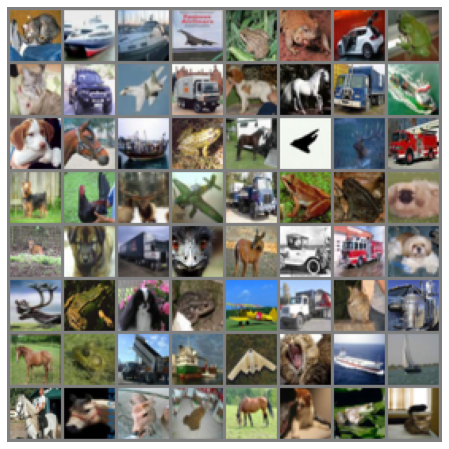

    TRUE        PREDICTED
-----------------------------
     cat           cat     
    ship          ship     
    ship          ship     
  airplane      airplane   
    frog          frog     
    frog          frog     
 automobile    automobile  
    frog          frog     
     cat           cat     
 automobile    automobile  
  airplane      airplane   
    truck         truck    
     dog           cat     
    horse         horse    
    truck         truck    
    ship          deer     
     dog           cat     
    horse         frog     
    ship          ship     
    frog          frog     
    horse         horse    
  airplane        bird     
    deer        airplane   
    truck         truck    
     dog          deer     
    bird          bird     
    deer          deer     
  airplane      airplane   
    truck         truck    
    frog          frog     
    frog           cat     
     dog          bird     
    deer          bird     
     dog          bi

In [36]:
inputs, targets = iter(test_loader).next()
inputs, targets = inputs.to(device), targets.to(device)
show_image(make_grid(inputs))
plt.show()

outputs = model(inputs)
_, predicted = torch.max(outputs.data, 1)

print("    TRUE        PREDICTED")
print("-----------------------------")
for target, pred in zip(targets, predicted):
    print(f"{classes[target.item()]:^13} {classes[pred.item()]:^13}")


We now evaluate the network as above, but on the entire test set.

In [37]:
# Evaluate test set
confusion_matrix = np.zeros((n_classes, n_classes))
with torch.no_grad():
    model.eval()
    test_accuracies = []
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        output = model(inputs)
        loss = loss_fn(output, targets)

        predictions = output.max(1)[1]

        # Multiply by len(inputs) because the final batch of DataLoader may be smaller (drop_last=True).
        test_accuracies.append(accuracy(targets, predictions) * len(inputs))
        
        confusion_matrix += compute_confusion_matrix(targets, predictions)

    test_accuracy = np.sum(test_accuracies) / len(test_set)
    
    model.train()


Here we report the **average test accuracy** (number of correct predictions divided by test set size).

In [38]:
print(f"Test accuracy: {test_accuracy:.3f}")

Test accuracy: 0.675


Here we look a bit more in depth into the performance of the classifier, using the **confusion matrix**. The entry at the i-th row and j-th column indicates the number of samples with true label being the i-th class and predicted label being the j-th class.

We normalize the rows: given all examples of a specific class (row), we can observe here how they are classified by our model. Ideally, we would like the entries on the diagonals to be 1, and everything else 0. This would mean that all examples from that class are classified correctly.

The classes that are harder to classify for our model have lower numbers on the diagonal. We can then see exactly *how* they are misclassified by looking at the rest of the row.


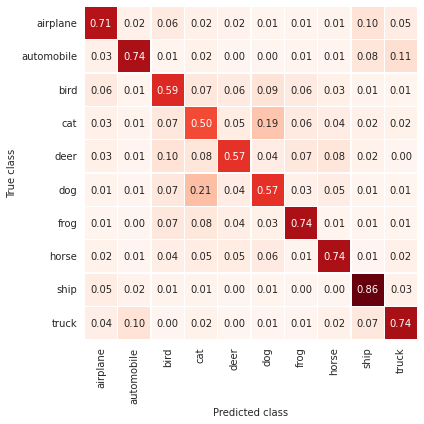

In [39]:
def normalize(matrix, axis):
    axis = {'true': 1, 'pred': 0}[axis]
    return matrix / matrix.sum(axis=axis, keepdims=True)

x_labels = [classes[i] for i in classes]
y_labels = x_labels
plt.figure(figsize=(6, 6))
sns.heatmap(
    ax=plt.gca(),
    data=normalize(confusion_matrix, 'true'),
    annot=True,
    linewidths=0.5,
    cmap="Reds",
    cbar=False,
    fmt=".2f",
    xticklabels=x_labels,
    yticklabels=y_labels,
)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.ylabel("True class")
plt.xlabel("Predicted class")
plt.tight_layout()
plt.show()

Here we focus on the diagonal and plot the numbers in a bar plot. This gives us a clearer picture of the accuracy of the model for different classes.

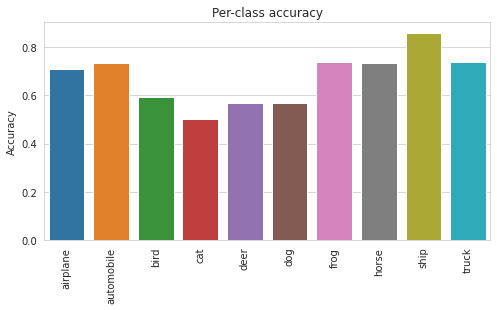

In [40]:
with sns.axes_style('whitegrid'):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=x_labels, y=np.diag(normalize(confusion_matrix, 'true')))
    plt.xticks(rotation=90)
    plt.title("Per-class accuracy")
    plt.ylabel("Accuracy")
    plt.show()

**Assignment 4:** 
1. Go back and improve performance of the network. By using enough convolutional layers with enough channels (and by training for long enough), you should easily be able to get a test accuracy above 60%, but see how much further you can get it! Can you reach 70%?

2. Briefly describe what you did and any experiments you did along the way as well as what results you obtained.
Did anything surprise you during the exercise?
What were the changes that seemed to improve performance the most?

3. Write down key lessons/insights you got during this exercise.

**Answer**

First, a more qualitative approach to improving the NN was done. Added a padding of one or both of the two convolutional layers. This seemed to improve the results a bit.

The removing of one or both pooling from the convolutional layers was also attempted. Removing it off one of them seemed to do near to nothing for the result. Removing both, however, worsened the results, or at least made it converge slower. The theory here, was that you lose information when pooling, so removing it might improve reults at the cost of time training. It of course also increases the amount of outputs going into the linear layers (whose number of nodes were kept constant, more on why later), which might explain the worse results.

The an ADAM optimizer was also attempted, but the SGD seemed to perform better.

Changed batchsize, from 64 to 128, where with 128 seemed to improve results.

Removing one of the convolutional layers, at first, didn't seem to affect the results, so only one convolutional layer could be the way to go. The setup before does seem do quite well though (or at least assumed), getting a test accuracy around 0.65 consistently.

Changing one thing, might change the effectiveness of any other setting, so, additionally, there was a more quantitative attempt. This was done with a sort of grid-search through the parameters chosen. However, this does of course increase computational time quite a bit, having to train so many networks. The for loops, with all of the different parts, is (almost) more than 300 different setups. Admittedly, with the previous different configurations, only 1/4 of them were tested, because of the limit on use of GPU power by google colab.

The parameters in the grid-search were the convolutional layers, 1 or 2 of them, the an amount of out channels of 10, 16 or 20, for the second convolutional layer, or the only convolutional layer when having just one of therese. The kernel size of 3x3, 5x5, or 7x7, with or without padding, with or without pooling of the singular or both convolutional layers, with or without dropout and/or batchnorm.

Of course more parameters could be included, but the amount of networks quickly increases. Therefore the loss (cross entropy) and activation function (ReLU) was kept the same, and the linear layer part of the network was chosen to be constant, which of course is a limitation, especially when it comes having more convolutional layers and pooling, as mentioned before.

Final average test accuracy high score was around 0.68.

TL;DR:

Final average test accuracy high score was around 0.68.

What seemed to improve the setup the most was batchsize when increased from 64 to 128, adding 1 layer of zero padding, 2x2 pooling, and, to a degree, another convolutional layer (2 total).

One learning is simply the time it takes to train just one setup of these kinds of NN. Add to that extensive testing, and it racks up quite a lot of time "quickly".
Also, with only an accuracy below 70%, there is still quite a way left to a high precision model, say above 99%.
Just the amount of complexity in general, with only such few (if few is the correct word is up for debate) parameters.


# Training on GPU

**Optional Assignment:**
If you have a GPU, we suggest that you try training your model on GPU. For this, you need to move the model to GPU after defining it, which will recursively go over all modules and convert their parameters and buffers to CUDA tensors. You also need to transfer both the inputs and targets to GPU at each training step, before performing the forward pass.

The code for this is already in place: notice the `.to(device)` statements. The only thing left to do is change the definition of `device` from `'cpu'` to `'cuda'`.

If you don't have a GPU, you can do this on [Google Colab](https://research.google.com/colaboratory/).

Use the code below to check if any GPU is avaiable in your current setup. This should print the models of all available GPUs.


In [ ]:
# Check if we have GPUs available
print("Available CUDA devices:", [torch.cuda.get_device_name(i) for i in range(torch.cuda.device_count())])

You may not notice any significant speed-up from using a GPU. This is probably because your network is really small. Try increasing the width of your network (number of channels in the convolutional layers) and see if you observe any speed-up on GPU compared to CPU.

# Exercise from Michael Nielsen's book

**Assignment 5:** Pick an exercise of your own choice from [Michael Nielsen's book](http://neuralnetworksanddeeplearning.com/).

Problem:

The idea of convolutional layers is to behave in an invariant way across images. It may seem surprising, then, that our network can learn more when all we've done is translate the input data. Can you explain why this is actually quite reasonable?

**Answer:**

As an introduction to the problem, a NN, with convolutional layers (so a CNN), is used and trained on the MNIST data. A trick, in the end, is translating the 50.000 images one pixel in each of the four directions, creating 200.000 new images for training, resulting in 250.000 in total.

The convolutional layers, as mentioned, behave in an invariant way across images. So the improvement comes either from pooling (if this was used), as the precise spatial information is blurred, so to speak, because of the reduction. So a translation can therefore improve these features, as the translated images will result in new pooling features, describing the same things, but moved, resulting in more information.

Another reason could be the fully connected linear layers at the end of the CNN network. As these layers still see spatial position, and more training should hopefully improve this.

A third thing could simply be the fact that the features initially extracted from the 50.000 pictures get exaggerated. For the fully connected layers, this point is simply a repetition of the second point.
